### This notebook takes code from `speculator`: https://github.com/justinalsing/speculator`

In [41]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import astropy.units as u
import kuaizi
import torch

In [43]:
kuaizi.set_matplotlib(style='nature', usetex=False)
kuaizi.set_env(project='popsed', name='', data_dir='/scratch/gpfs/jiaxuanl/Data')

'/scratch/gpfs/jiaxuanl/Data/popsed/'

In [44]:
import sys
sys.path.append('/home/jiaxuanl/Research/popsed/')
from popsed.speculator import Speculator

In [48]:
speculator = Speculator(n_parameters=2,
                        pca_filename='./train_sed/pca_trained.pkl', 
                        hidden_size=[256, 256, 256])

In [49]:
flag = np.array([ True,  True,  True,  True,  True, False,  True,  True, False])
zero_flag = (np.mean(np.load('./train_sed/log_spec_all.npy'), axis=1) < -30)

log_spec_all = np.load('./train_sed/log_spec_all.npy')[~zero_flag]
pca_coeff = np.load('./train_sed/pca_coeffs.npy')[~zero_flag]
params = np.load('./train_sed/param_all.npy')[:, ~flag][~zero_flag]

In [52]:
speculator.load_data(pca_coeff, params, val_frac=0.1, batch_size=128)
train_ind = speculator.dataloaders['train'].dataset.indices
val_ind = speculator.dataloaders['val'].dataset.indices

In [53]:
%%time
n_ep = [200, 100, 150, 500]
for i, lr in enumerate([2e-3, 1e-3, 5e-4, 3e-4]):
    speculator.train(learning_rate=lr, n_epochs=n_ep[i])

Epoch: 0 - train Loss: 0.0083
Epoch: 0 - val Loss: 0.0807
Epoch: 100 - train Loss: 0.0012
Epoch: 100 - val Loss: 0.0117
Epoch: 0 - train Loss: 0.0008
Epoch: 0 - val Loss: 0.0078
Epoch: 0 - train Loss: 0.0003
Epoch: 0 - val Loss: 0.0033
Epoch: 100 - train Loss: 0.0001
Epoch: 100 - val Loss: 0.0013
Epoch: 0 - train Loss: 0.0002
Epoch: 0 - val Loss: 0.0022
Epoch: 100 - train Loss: 0.0001
Epoch: 100 - val Loss: 0.0008
Epoch: 200 - train Loss: 0.0001
Epoch: 200 - val Loss: 0.0008
Epoch: 300 - train Loss: 0.0001
Epoch: 300 - val Loss: 0.0007
Epoch: 400 - train Loss: 0.0001
Epoch: 400 - val Loss: 0.0007
CPU times: user 53.5 s, sys: 5.41 s, total: 58.9 s
Wall time: 1min 3s


In [150]:
# %%time
# # n_ep = [100, 100, 150, 500, 500]
# # for i, lr in enumerate([2e-3, 1e-3, 5e-4, 3e-4, 1e-4]):
# n_ep = [200, 200, 200, 200, 200]
# for i, lr in enumerate([2e-3, 1e-3, 5e-4, 3e-4, 2e-4]):
#     speculator.train(learning_rate=lr, n_epochs=n_ep[i])

In [54]:
speculator.best_recon_err_epoch

498

In [55]:
speculator.best_loss_epoch

492

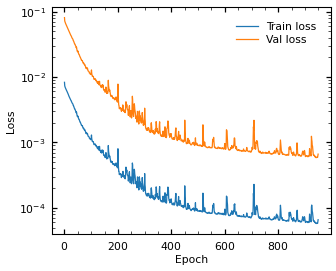

In [56]:
speculator.plot_loss()

In [70]:
## Load the NN emulator `speculator`
with open('./best_recon_err_model.pkl', 'rb') as f:
    speculator = pickle.load(f)

In [71]:
_specs = speculator.predict_spec(params).cpu().detach().numpy()

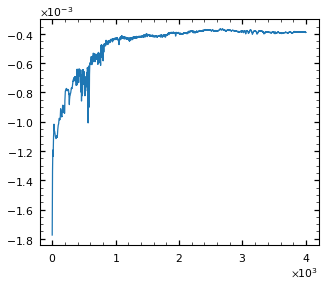

In [72]:
plt.plot(np.median(_specs - log_spec_all, axis=0))

In [73]:
diff = (10**log_spec_all - 10**_specs) / 10**log_spec_all * 100
diff = diff[val_ind]

In [74]:
from scipy.stats import norm

(380.0, 700.0)

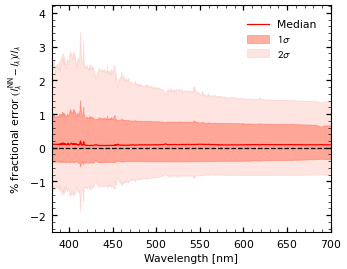

In [75]:
x = np.arange(3000, 11000, 2) / 10
plt.plot(x, np.median(diff, axis=0), color='r', label='Median')
plt.fill_between(x, 
                 np.percentile(diff, (1 - norm.cdf(1)) * 100, axis=0), 
                 np.percentile(diff, norm.cdf(1) * 100, axis=0), alpha=0.5, color='tomato', label=r'$1\sigma$')

plt.fill_between(x, 
                 np.percentile(diff, (1 - norm.cdf(2)) * 100, axis=0), 
                 np.percentile(diff, norm.cdf(2) * 100, axis=0), alpha=0.2, color='salmon', label=r'$2\sigma$')

#plt.ylim(-0.008, 0.008)

plt.ylabel(r'% fractional error $(l_{\lambda}^{\mathrm{NN}} - l_{\lambda})/l_{\lambda}$')
plt.xlabel('Wavelength [nm]')

plt.hlines(0, 380, 700, ls='--', color='k')
plt.legend()

plt.xlim(380, 700)

In [76]:
val_ind[20]

1335

Text(0, 0.5, 'Flux Density (normalized to 1 $M_\\odot$)')

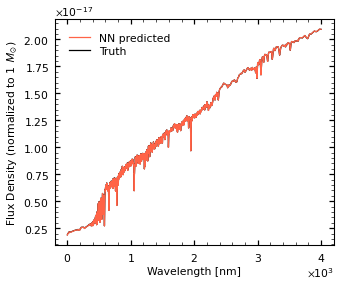

In [77]:
plt.plot(10**_specs[1335], label='NN predicted', alpha=1, color='tomato', zorder=3)
plt.plot(10**log_spec_all[1335], label='Truth', alpha=1, color='k')

plt.legend()
plt.xlabel('Wavelength [nm]')
plt.ylabel(r'Flux Density (normalized to 1 $M_\odot$)')

### From spectrum to magnitudes

In [78]:
## Load the NN emulator `speculator`
with open('./best_loss_model.pkl', 'rb') as f:
    speculator = pickle.load(f)

In [79]:
flag = np.array([ True,  True,  True,  True,  True, False,  True,  True, False])
zero_flag = (np.mean(np.load('./train_sed/log_spec_all.npy'), axis=1) < -30)

log_spec_all = np.load('./train_sed/log_spec_all.npy')[~zero_flag]
pca_coeff = np.load('./train_sed/pca_coeffs.npy')[~zero_flag]
params = np.load('./train_sed/param_all.npy')[:, ~flag][~zero_flag]

In [85]:
mags = speculator.predict_sed(params, 
                              filterset=['sdss_u0', 'sdss_g0', 'sdss_r0', 'sdss_i0', 'sdss_z0'], 
                              angstroms=np.arange(3000, 11000, 2))

In [90]:
-2.5 * np.log10(np.load('./train_sed/phot_all.npy')[~zero_flag])

array([[43.63864672, 42.06831069, 41.56953812, 41.3368604 , 41.12897138],
       [43.63553441, 42.06617217, 41.56935345, 41.33762185, 41.13036139],
       [43.63160371, 42.06346599, 41.56911302, 41.33857782, 41.13211328],
       ...,
       [44.11538942, 42.99839819, 42.50473113, 42.24415294, 42.00137055],
       [44.09133605, 42.97880175, 42.48886046, 42.22988072, 41.98838879],
       [44.07232059, 42.96327754, 42.47626487, 42.21854561, 41.97807198]])

In [86]:
mags

array([[43.6430218 , 42.07568827, 41.57702638, 41.34426676, 41.13704345],
       [43.62080704, 42.05849851, 41.56526769, 41.33486451, 41.12919448],
       [43.61133412, 42.05101652, 41.56127152, 41.3325158 , 41.12799949],
       ...,
       [44.1096385 , 42.99533044, 42.50392588, 42.24405187, 42.00238434],
       [44.0869134 , 42.97632768, 42.48810673, 42.22966604, 41.98914665],
       [44.0678413 , 42.95984695, 42.4739033 , 42.21655814, 41.97690546]])